# Definitions

In [1]:
# Metrics
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import zip_longest
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
np.set_printoptions(edgeitems=1000, linewidth=100000, 
    formatter=dict(float=lambda x: "%.1f" % x))

## Formatter

In [2]:
def fmt_div_e5(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 100000)
    return s


def fmt_div_e3(x, pos): # your custom formatter function: divide y axis tick labels by 1000.0
    s = '{}'.format(x / 1000)
    return s


def fmt_div_e7(x, pos): # your custom formatter function: divide y axis tick labels by 10000000.0
    s = '{}'.format(x / 10000000)
    return s

def fmt_mul_e2(x, pos): # your custom formatter function: multiply y axis tick labels by 100.0
    s = '{}'.format(x * 100)
    return s


def minutes(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 60000)
    return s

def ms_to_sec(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 1000)
    return s

def sec_to_min(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{:.2f}'.format(x / 60)
    return s

## Plotter


In [3]:
def plot_aggregated_dict(title, inputs, labels, markers, linestyles, colors, fit_degree=None, formatter=None, ylabel=None, xlabel=None, pre_fig=None):
    x = np.array(sorted(inputs[0].keys()))
    y = list(map(lambda x: np.array([]), inputs))
    lines = list()
    for key in x:
        for i, _ in enumerate(y):
            if key not in inputs[i]:
                inputs[i][key] = 0
            val = np.array(inputs[i][key])
            y[i] = np.append(y[i], val)
    fig, ax = plt.subplots() if pre_fig is None else pre_fig
    for i, yi in enumerate(y):
        if fit_degree:
            theta = np.poly1d(np.polyfit(x, y[i], fit_degree))
            fit_line = theta(x)
            lines.append(ax.scatter(x, yi, label=labels[i], marker=markers[i], color=colors[i], linestyle=linestyles[i]))
            lines.append(ax.plot(x, fit_line, label=None, marker=None, linestyle=":")[0])
            
        else:
            lines.append(ax.plot(x, yi, label=labels[i], marker=markers[i], color=colors[i], linestyle=linestyles[i])[0])
    if formatter is not None:
        ax.yaxis.set_major_formatter(formatter)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return (fig, ax, lines)

## Statistics Measurer

In [4]:
class MetricStatistics:
    def __init__(self, entry_folder_name="metrics", operator_name="GNN Operator - 2", metric_name="numRecordsInPerSecond", is_lambda=False):
        """ 
        Folders are organized as follows:
        entry_folder -> run -> operator_name -> metric_name -> subtask_index[digit]
        Output is as follows:
        parallelism -> experiments[] -> subtask[] -> metric_values[]
        """
        self.output = defaultdict(list)
        for run in os.listdir(entry_folder_name):
            if not os.path.isdir(os.path.join(entry_folder_name, run)):
                continue
            subtasks = []
            for subtask_index in (os.listdir(os.path.join(entry_folder_name, run, operator_name, metric_name))):
                if not subtask_index.isdigit():
                    continue
                f = pd.read_csv(os.path.join(entry_folder_name, run, operator_name, metric_name,subtask_index), header=None, names=["value"])
                subtasks.append(f["value"].values)
                
            run_class = int(re.match(".*\((\d+)\).*",run).groups()[0]) if not is_lambda else float(re.match(".*-l=(\d+.\d+).*",run).groups()[0])
            self.output[run_class].append(subtasks)
            
    def transform_metrics(self, transformation):
        """ Apply Transformation to each metric array in a subtask """
        for experiments in self.output.values():
            for experiment in experiments:
                for subtask_index in range(len(experiment)):
                    if callable(transformation):
                        experiment[subtask_index] = transformation(experiment[subtask_index])
                    elif transformation == "trim_zeros":
                        experiment[subtask_index] = np.trim_zeros(experiment[subtask_index],"fb")
                    elif transformation == "trim_zeros_back":
                        experiment[subtask_index] = np.trim_zeros(experiment[subtask_index],"b")
                    elif transformation == "trim_zeros_front":
                        experiment[subtask_index] = np.trim_zeros(experiment[subtask_index],"f")
                    elif transformation == "mean":
                        experiment[subtask_index] = np.mean(experiment[subtask_index])
                    elif transformation == "max":
                        experiment[subtask_index] = np.max(experiment[subtask_index])
                    elif transformation == "expand_dim":
                        experiment[subtask_index] = np.expand_dims(experiment[subtask_index], -1)
                        
        return self
        
    def transform_subtasks(self, transformation):
        """ Apply transformation to all subtasks """
        for experiments in self.output.values():
            for experiment_index in range(len(experiments)):
                if callable(transformation):
                    experiments[experiment_index] = transformation(experiments[experiment_index])
                elif transformation == "sum_0_axis":
                    max_len = max([len(x) for x in experiments[experiment_index]])
                    output = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in experiments[experiment_index]])
                    experiments[experiment_index] = np.sum(output, axis=0)
                elif transformation == "mean_0_axis":
                    max_len = max([len(x) for x in experiments[experiment_index]])
                    output = np.vstack([np.pad(x.astype(float), (0, max_len - len(x)), 'constant', constant_values=np.nan) for x in experiments[experiment_index]])
                    experiments[experiment_index] = np.nanmean(output, axis=0)
                elif transformation == "max_0_axis":
                    max_len = max([len(x) for x in experiments[experiment_index]])
                    output = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in experiments[experiment_index]])
                    experiments[experiment_index] = np.max(output, axis=0)
        return self
    
    def transform_experiment(self, transformation):
        """ Apply transformation to all experiments """
        for key, experiments in self.output.items():
            if callable(transformation):
                self.output[key] = transformation(experiments)
            elif transformation == "mean_0_axis":
                max_len = max([len(x) for x in experiments])
                output = np.vstack([np.pad(x.astype(float), (0, max_len - len(x)), 'constant', constant_values=np.nan) for x in experiments])
                self.output[key] = np.nanmean(output, axis=0)
            elif transformation == "max_0_axis":
                max_len = max([len(x) for x in experiments])
                output = np.vstack([np.pad(x, (0, max_len - len(x)), 'constant') for x in experiments])
                self.output[key] = np.max(output, axis=0)
        return self
    
    def get_mean_throughput(self):
        """ Get Mean Throughput """
        self.transform_metrics("trim_zeros")
        self.transform_subtasks("sum_0_axis")
        self.transform_subtasks(lambda x: np.array([x.mean()]))
        return self.transform_experiment("mean_0_axis").transform_experiment(lambda a: a[0])
    
    def get_max_throughput(self):
        """ Get Max Throughput """
        self.transform_metrics("trim_zeros")
        self.transform_subtasks("sum_0_axis")
        self.transform_subtasks(lambda x: np.array([x.max()]))
        return self.transform_experiment("mean_0_axis").transform_experiment(lambda a: a[0])
        
    def get_communication_volume(self):
        """ Get Communication volume """
        self.transform_metrics("max").transform_metrics("expand_dim")
        self.transform_subtasks("sum_0_axis")
        return self.transform_experiment("mean_0_axis").transform_experiment(lambda a: a[0])
    
    def get_replication_factor(self):
        """ Get Partitioner Replication Factor """
        self.transform_metrics(lambda x: np.array([x[-1]]))
        self.transform_subtasks("sum_0_axis")
        self.transform_experiment("mean_0_axis")
        return self
    
    def get_runtime(self):
        """ Get runtime of this operator """
        self.transform_metrics("trim_zeros_back")
        self.transform_metrics(lambda x: np.array([x.shape[0]]))
        self.transform_subtasks("max_0_axis")
        self.transform_experiment("mean_0_axis")
        return self
    
    
    def get_accuracy(self):
        """ Get runtime of this operator """
        self.transform_metrics("trim_zeros_back")
        self.transform_metrics("trim_zeros_front")
        self.transform_subtasks("mean_0_axis")
        self.transform_experiment("mean_0_axis")
        return self 

## Process Folder

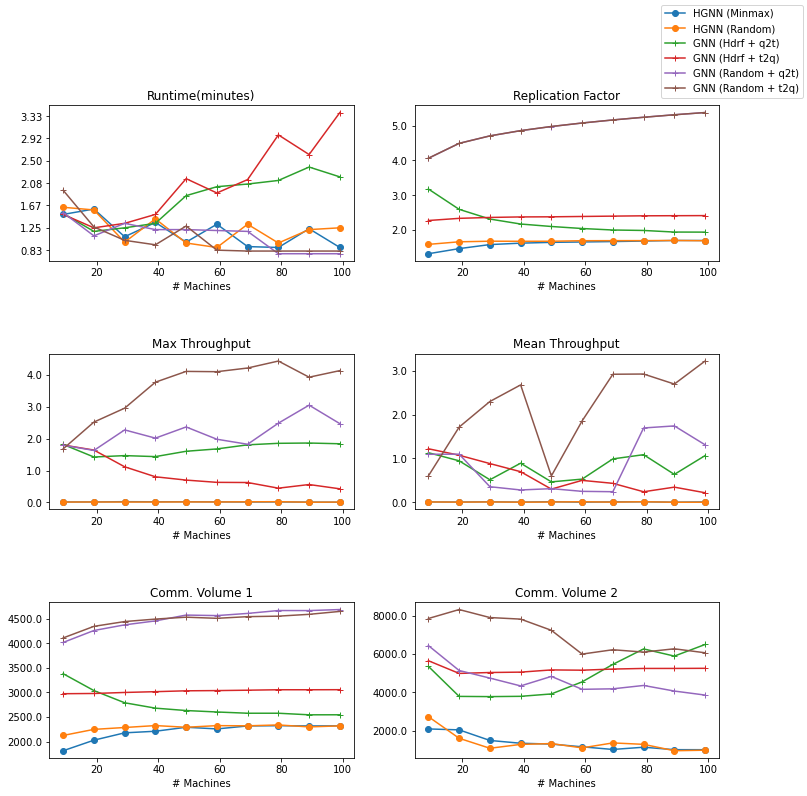

In [5]:
fig, ax = plt.subplots(3,2, figsize=(12,12), gridspec_kw={"hspace":0.6})

random_graph_q2t = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_q2t/", operator_name="GNN Operator - 2", metric_name="numRecordsOutPerSecond").get_runtime()
random_graph_t2q = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_t2q/", operator_name="GNN Operator - 2", metric_name="numRecordsOutPerSecond").get_runtime()
random_hypergraph_runtime = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_hypergraph/", operator_name="GNN Operator - 2", metric_name="numRecordsOutPerSecond").get_runtime()
hdrf_q2t = MetricStatistics(entry_folder_name="../../metrics/3.12.22/hdrf_q2t/", operator_name="GNN Operator - 2", metric_name="numRecordsOutPerSecond").get_runtime()
hdrf_t2q = MetricStatistics(entry_folder_name="../../metrics/3.12.22/hdrf_t2q/", operator_name="GNN Operator - 2", metric_name="numRecordsOutPerSecond").get_runtime()
minmax = MetricStatistics(entry_folder_name="../../metrics/3.12.22/minmax/", operator_name="GNN Operator - 2", metric_name="numRecordsOutPerSecond").get_runtime()
plot_aggregated_dict("Runtime(minutes)", [minmax.output,random_hypergraph_runtime.output, hdrf_q2t.output, hdrf_t2q.output, random_graph_q2t.output,random_graph_t2q.output,  ], 
                     ["HGNN (Minmax)","HGNN (Random)", "GNN (Hdrf + q2t)","GNN (Hdrf + t2q)", "GNN (Random + q2t)", "GNN (Random + t2q)"], ["o","o", "+", "+","+","+" ], ["-","-", "-", "-","-","-"], [None,None, None, None, None, None], xlabel="# Machines", formatter=sec_to_min, pre_fig=(fig,ax[0][0]))

random_graph_q2t = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_q2t/",  operator_name="Random Partitioner", metric_name="Replication Factor").get_replication_factor()
random_graph_t2q = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_t2q/", operator_name="Random Partitioner", metric_name="Replication Factor").get_replication_factor()
random_hypergraph_runtime = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_hypergraph/", operator_name="Random Partitioner", metric_name="Replication Factor").get_replication_factor()
hdrf_q2t = MetricStatistics(entry_folder_name="../../metrics/3.12.22/hdrf_q2t/", operator_name="HDRF[l=4.0,eps=1.0,threads=1]", metric_name="Replication Factor").get_replication_factor()
hdrf_t2q = MetricStatistics(entry_folder_name="../../metrics/3.12.22/hdrf_t2q/", operator_name="HDRF[l=4.0,eps=1.0,threads=1]", metric_name="Replication Factor").get_replication_factor()
minmax = MetricStatistics(entry_folder_name="../../metrics/3.12.22/minmax/", operator_name="HyperGraphMinMax", metric_name="Replication Factor").get_replication_factor()
plot_aggregated_dict("Replication Factor", [minmax.output,random_hypergraph_runtime.output, hdrf_q2t.output, hdrf_t2q.output, random_graph_q2t.output,random_graph_t2q.output,  ], 
                     ["HGNN (Minmax)","HGNN (Random)", "GNN (Hdrf + q2t)","GNN (Hdrf + t2q)", "GNN (Random + q2t)", "GNN (Random + t2q)"], ["o","o", "+", "+","+","+" ], ["-","-", "-", "-","-","-"], [None,None, None, None, None, None], xlabel="# Machines", formatter=fmt_div_e3, pre_fig=(fig,ax[0][1]))


random_graph_q2t = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_q2t/",  metric_name="throughput").get_max_throughput()
random_graph_t2q = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_t2q/", metric_name="throughput").get_max_throughput()
random_hypergraph_runtime = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_hypergraph/", metric_name="throughput").get_max_throughput()
hdrf_q2t = MetricStatistics(entry_folder_name="../../metrics/3.12.22/hdrf_q2t/", metric_name="throughput").get_max_throughput()
hdrf_t2q = MetricStatistics(entry_folder_name="../../metrics/3.12.22/hdrf_t2q/", metric_name="throughput").get_max_throughput()
minmax = MetricStatistics(entry_folder_name="../../metrics/3.12.22/minmax/", metric_name="throughput").get_max_throughput()
plot_aggregated_dict("Max Throughput", [minmax.output,random_hypergraph_runtime.output, hdrf_q2t.output, hdrf_t2q.output, random_graph_q2t.output,random_graph_t2q.output,  ], 
                     ["HGNN (Minmax)","HGNN (Random)", "GNN (Hdrf + q2t)","GNN (Hdrf + t2q)", "GNN (Random + q2t)", "GNN (Random + t2q)"], ["o","o", "+", "+","+","+" ], ["-","-", "-", "-","-","-"], [None,None, None, None, None, None], xlabel="# Machines", formatter=fmt_div_e5, pre_fig=(fig,ax[1][0]))

random_graph_q2t = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_q2t/",  metric_name="throughput").get_mean_throughput()
random_graph_t2q = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_t2q/", metric_name="throughput").get_mean_throughput()
random_hypergraph_runtime = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_hypergraph/", metric_name="throughput").get_mean_throughput()
hdrf_q2t = MetricStatistics(entry_folder_name="../../metrics/3.12.22/hdrf_q2t/", metric_name="throughput").get_mean_throughput()
hdrf_t2q = MetricStatistics(entry_folder_name="../../metrics/3.12.22/hdrf_t2q/", metric_name="throughput").get_mean_throughput()
minmax = MetricStatistics(entry_folder_name="../../metrics/3.12.22/minmax/", metric_name="throughput").get_mean_throughput()
plot_aggregated_dict("Mean Throughput", [minmax.output,random_hypergraph_runtime.output, hdrf_q2t.output, hdrf_t2q.output, random_graph_q2t.output,random_graph_t2q.output,  ], 
                     ["HGNN (Minmax)","HGNN (Random)", "GNN (Hdrf + q2t)","GNN (Hdrf + t2q)", "GNN (Random + q2t)", "GNN (Random + t2q)"], ["o","o", "+", "+","+","+" ], ["-","-", "-", "-","-","-"], [None,None, None, None, None, None], xlabel="# Machines", formatter=fmt_div_e5, pre_fig=(fig,ax[1][1]))

random_graph_q2t = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_q2t/",  operator_name="GNN Operator - 1", metric_name="numRecordsOut").get_communication_volume()
random_graph_t2q = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_t2q/", operator_name="GNN Operator - 1", metric_name="numRecordsOut").get_communication_volume()
random_hypergraph_runtime = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_hypergraph/", operator_name="GNN Operator - 1", metric_name="numRecordsOut").get_communication_volume()
hdrf_q2t = MetricStatistics(entry_folder_name="../../metrics/3.12.22/hdrf_q2t/", operator_name="GNN Operator - 1", metric_name="numRecordsOut").get_communication_volume()
hdrf_t2q = MetricStatistics(entry_folder_name="../../metrics/3.12.22/hdrf_t2q/", operator_name="GNN Operator - 1", metric_name="numRecordsOut").get_communication_volume()
minmax = MetricStatistics(entry_folder_name="../../metrics/3.12.22/minmax/", operator_name="GNN Operator - 1", metric_name="numRecordsOut").get_communication_volume()
plot_aggregated_dict("Comm. Volume 1", [minmax.output,random_hypergraph_runtime.output, hdrf_q2t.output, hdrf_t2q.output, random_graph_q2t.output,random_graph_t2q.output,  ], 
                     ["HGNN (Minmax)","HGNN (Random)", "GNN (Hdrf + q2t)","GNN (Hdrf + t2q)", "GNN (Random + q2t)", "GNN (Random + t2q)"], ["o","o", "+", "+","+","+" ], ["-","-", "-", "-","-","-"], [None,None, None, None, None, None], xlabel="# Machines", formatter=fmt_div_e3, pre_fig=(fig,ax[2][0]))

random_graph_q2t = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_q2t/",  operator_name="GNN Operator - 2", metric_name="numRecordsOut").get_communication_volume()
random_graph_t2q = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_t2q/", operator_name="GNN Operator - 2", metric_name="numRecordsOut").get_communication_volume()
random_hypergraph_runtime = MetricStatistics(entry_folder_name="../../metrics/3.12.22/random_hypergraph/", operator_name="GNN Operator - 2", metric_name="numRecordsOut").get_communication_volume()
hdrf_q2t = MetricStatistics(entry_folder_name="../../metrics/3.12.22/hdrf_q2t/", operator_name="GNN Operator - 2", metric_name="numRecordsOut").get_communication_volume()
hdrf_t2q = MetricStatistics(entry_folder_name="../../metrics/3.12.22/hdrf_t2q/", operator_name="GNN Operator - 2", metric_name="numRecordsOut").get_communication_volume()
minmax = MetricStatistics(entry_folder_name="../../metrics/3.12.22/minmax/", operator_name="GNN Operator - 2", metric_name="numRecordsOut").get_communication_volume()
plot_aggregated_dict("Comm. Volume 2", [minmax.output,random_hypergraph_runtime.output, hdrf_q2t.output, hdrf_t2q.output, random_graph_q2t.output,random_graph_t2q.output,  ], 
                     ["HGNN (Minmax)","HGNN (Random)", "GNN (Hdrf + q2t)","GNN (Hdrf + t2q)", "GNN (Random + q2t)", "GNN (Random + t2q)"], ["o","o", "+", "+","+","+" ], ["-","-", "-", "-","-","-"], [None,None, None, None, None, None], xlabel="# Machines", formatter=fmt_div_e3, pre_fig=(fig,ax[2][1]))


fig.legend(ax[0][0].get_legend_handles_labels()[1])

## OGB_Accuracy

In [82]:
random_graph_runtime = MetricStatistics(entry_folder_name="../../metrics/ogb-products/", operator_name="GNN Operator - 3", metric_name="accuracy").get_accuracy()

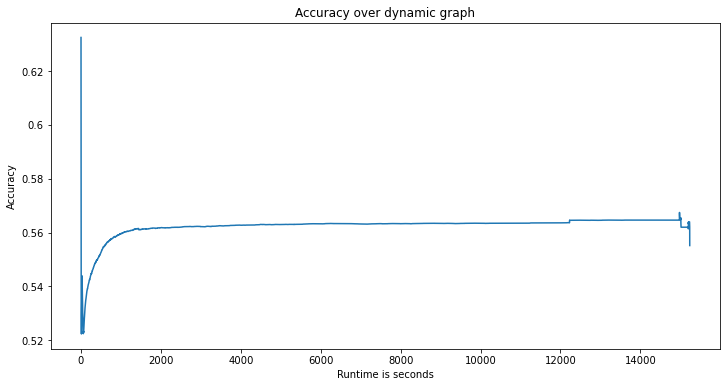

In [89]:
fig, ax = plt.subplots(figsize=(12,6))
ax.yaxis.set_major_formatter(fmt_div_e3)
ax.set_title("Accuracy over dynamic graph")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Runtime is seconds")
plt.plot(np.arange(0, random_graph_runtime.output[57].shape[0]),random_graph_runtime.output[57])
plt.savefig("accuracy")

In [79]:
random_graph_runtime = MetricStatistics(entry_folder_name="../../metrics/ogb-products/", operator_name="Parser OGB-Products", metric_name="numRecordsOut").transform_subtasks("sum_0_axis").transform_experiment("mean_0_axis")

In [80]:
np.where(random_graph_runtime.output[57] > 5000000)

(array([   67,    68,    69,    70,    71,    72,    73,    74,    75,    76,    77,    78,    79,    80,    81,    82,    83,    84,    85,    86,    87,    88,    89,    90,    91,    92,    93,    94,    95,    96,    97,    98,    99,   100,   101,   102,   103,   104,   105,   106,   107,   108,   109,   110,   111,   112,   113,   114,   115,   116,   117,   118,   119,   120,   121,   122,   123,   124,   125,   126,   127,   128,   129,   130,   131,   132,   133,   134,   135,   136,   137,   138,   139,   140,   141,   142,   143,   144,   145,   146,   147,   148,   149,   150,   151,   152,   153,   154,   155,   156,   157,   158,   159,   160,   161,   162,   163,   164,   165,   166,   167,   168,   169,   170,   171,   172,   173,   174,   175,   176,   177,   178,   179,   180,   181,   182,   183,   184,   185,   186,   187,   188,   189,   190,   191,   192,   193,   194,   195,   196,   197,   198,   199,   200,   201,   202,   203,   204,   205,   206,   207,   208